### import & 데이터 가져오기 & 데이터 합치기 & 형식 변환

In [4]:
# 데이터 처리
import pandas as pd
import numpy as np

# 머신러닝
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 기타
from datetime import datetime

In [5]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
geo_df =  pd.read_csv("olist_geolocation_dataset.csv")
order_items_df =  pd.read_csv("olist_order_items_dataset.csv")
order_payments_df =  pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df =  pd.read_csv("olist_order_reviews_dataset.csv")
orders_df =  pd.read_csv("olist_orders_dataset.csv")
products_df =  pd.read_csv("olist_products_dataset.csv")
sellers_df =  pd.read_csv("olist_sellers_dataset.csv")
category_name_df =  pd.read_csv("product_category_name_translation.csv")

In [8]:
# 주문(orders)을 중심으로 아이템(items)과 리뷰(reviews) 합치기

main_df = pd.merge(orders_df, order_items_df, on='order_id', how='left')
main_df = pd.merge(main_df, order_reviews_df, on='order_id', how='left')
main_df = pd.merge(main_df, order_payments_df, on='order_id', how='left')

# 날짜 데이터 형식 변환 
main_df['order_purchase_timestamp'] = pd.to_datetime(main_df['order_purchase_timestamp'])
main_df['order_delivered_customer_date'] = pd.to_datetime(main_df['order_delivered_customer_date'])
main_df['order_estimated_delivery_date'] = pd.to_datetime(main_df['order_estimated_delivery_date'])
main_df['shipping_limit_date'] = pd.to_datetime(main_df['shipping_limit_date'])

### 결측치 처리 (= 지연 여부와 리뷰 점수가 없는 데이터 )

In [17]:
# 배송 지연 여부를 판단할 수 없는 데이터 제거 _ 실제 배송일이 없는 경우
main_df = main_df.dropna(subset=['order_delivered_customer_date', 'shipping_limit_date'])

# 리뷰 점수가 없는 데이터 제거
main_df = main_df.dropna(subset=['review_score'])

# 리뷰 메시지 결측치는 '내용 없음'으로 채우기 
main_df['review_comment_message'] = main_df['review_comment_message'].fillna('')

print(f"통합 및 정제 완료 데이터: {len(main_df)}")

통합 및 정제 완료 데이터: 114861


### 지연 지표 생성 및 확인 

In [50]:
# 예정일보다 실제 배송일이 늦었으면 True, 아니면 False
main_df['is_delayed'] = main_df['order_delivered_customer_date'] > main_df['order_estimated_delivery_date']

# 리뷰 메시지가 있는지 여부 확인
main_df['has_review_message'] = main_df['review_comment_message'] != ''

In [22]:
# True(지연)와 False(정상)의 개수 및 비율 확인
delay_counts = main_df['is_delayed'].value_counts()
delay_rates = main_df['is_delayed'].value_counts(normalize=True) * 100

print("--- 배송 지연 여부(is_delayed) 분포 ---")
print(f"개수 합계:\n{delay_counts}")
print(f"\n비율(%%):\n{delay_rates.round(2)}")

--- 배송 지연 여부(is_delayed) 분포 ---
개수 합계:
is_delayed
False    105998
True       8863
Name: count, dtype: int64

비율(%%):
is_delayed
False    92.28
True      7.72
Name: proportion, dtype: float64


In [24]:
# 지연된 데이터(True)와 정상 데이터(False) 확인

check_cols = ['order_id', 'order_estimated_delivery_date', 'order_delivered_customer_date', 'is_delayed']

print("\n--- 지연 데이터(True) ---")
print(main_df[main_df['is_delayed'] == True][check_cols].head())

print("\n--- 정상 데이터(False) ---")
print(main_df[main_df['is_delayed'] == False][check_cols].head())


--- 지연 데이터(True) ---
                            order_id order_estimated_delivery_date  \
26  203096f03d82e0dffbc41ebc2e2bcfb7                    2017-09-28   
31  fbf9ac61453ac646ce8ad9783d7d0af6                    2018-03-12   
42  8563039e855156e48fccee4d611a3196                    2018-03-20   
48  6ea2f835b4556291ffdc53fa0b3b95e8                    2017-12-21   
65  66e4624ae69e7dc89bd50222b59f581f                    2018-04-02   

   order_delivered_customer_date  is_delayed  
26           2017-10-09 22:23:00        True  
31           2018-03-21 22:03:00        True  
42           2018-03-20 00:59:00        True  
48           2017-12-28 18:59:00        True  
65           2018-04-03 13:28:00        True  

--- 정상 데이터(False) ---
                           order_id order_estimated_delivery_date  \
0  e481f51cbdc54678b7cc49136f2d6af7                    2017-10-18   
1  e481f51cbdc54678b7cc49136f2d6af7                    2017-10-18   
2  e481f51cbdc54678b7cc49136f2d6af7          

### 지연 많이 일으키는 셀러 10

In [43]:
# 셀러별 지연 통계 계산
seller_ranking = main_df.groupby('seller_id').agg({
    'order_id': 'nunique',        # 총 주문 건수
    'is_delayed': ['sum', 'mean'] # 지연 건수 합계, 지연율(평균)
}).reset_index()

# 컬럼명 정리
seller_ranking.columns = ['seller_id', 'total_orders', 'delay_count', 'delay_rate']

# delay_rate 백분율(%)로 변환
seller_ranking['delay_rate_pct'] = (seller_ranking['delay_rate'] * 100).round(0)

# 분석 신뢰도를 위해 최소 주문 건수(10건 이상) 기준 설정
top_risk_sellers = seller_ranking[seller_ranking['total_orders'] >= 10].sort_values(by='delay_rate_pct', ascending=False)

print("--- [지연율이 높은 '유의 판매자' TOP 10 (%) ---")
print(top_risk_sellers[['seller_id', 'total_orders', 'delay_count', 'delay_rate_pct']].head(10))

--- [지연율이 높은 '유의 판매자' TOP 10 (%) ---
                             seller_id  total_orders  delay_count  \
2049  b1b3948701c5c72445495bd161b83a4c            14            9   
450   2709af9587499e95e803a6498a5a56e9            24           23   
2265  c37b2059d4f90d4feead554e5246565e            12            7   
31    02dcd3e8e25bee036e32512bcf175493            13            7   
2868  f76a3b1349b6df1ee875d1f3fa4340f0            24           10   
30    02d35243ea2e497335cd0f076b45675d            14            6   
1553  835f0f7810c76831d6c7d24c7a646d4d            42           19   
2455  d32e3909cfb714fb2a6cb092c85b9c5f            10            5   
2370  cb41bfbcbda0aea354a834ab222f9a59            11            4   
1719  91f0eec23d4a61d7d7caeefa3f0ad1ca            11            4   

      delay_rate_pct  
2049            64.0  
450             50.0  
2265            44.0  
31              41.0  
2868            40.0  
30              38.0  
1553            37.0  
2455            36.

In [ ]:
# delay_count : 지연 건수 합계 (실제 배송일이 늦어진 주문의 총 개수)
# delay_rate : 지연율 (지연건수 / 총 주문 건수) 

### 배송 지연 여부에 따른 리뷰 점수 분포 

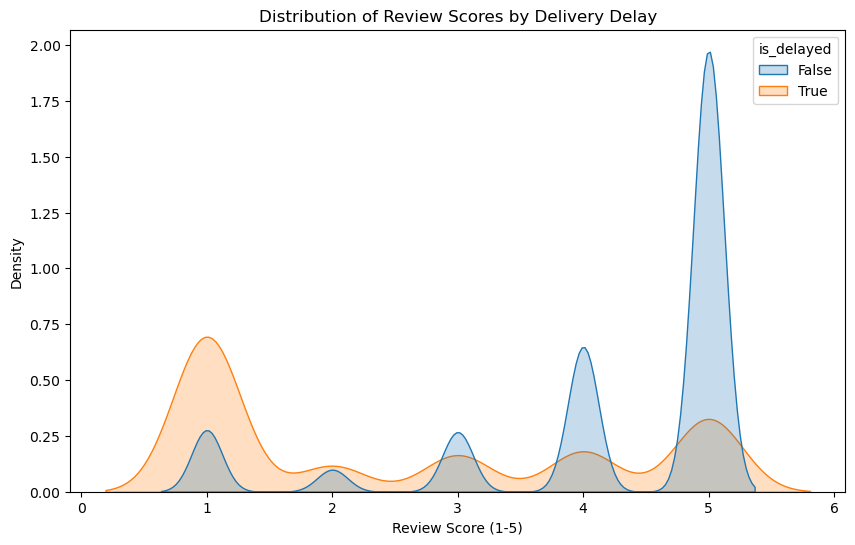

--- 지연 여부 별 리뷰 점수 개수 ---
review_score   1.0   2.0   3.0    4.0    5.0
is_delayed                                  
False         8965  3206  8670  21068  64089
True          4156   693   980   1082   1952


In [51]:
# 지연이 발생했을 때 평점이 어느 구간으로 가장 많이 쏠리는지 확인 
# 유의 판매자가 플랫폼에 입히는 평판 타격 

# 지연 여부에 따른 리뷰 점수 분포 (Density Plot)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=main_df, x='review_score', hue='is_delayed', common_norm=False, fill=True)
plt.title('Distribution of Review Scores by Delivery Delay')
plt.xlabel('Review Score (1-5)')
plt.ylabel('Density')
plt.show()

# 수치로 확인 (지연 여부별 평점 빈도)
score_dist = main_df.groupby(['is_delayed', 'review_score']).size().unstack(fill_value=0)
print("--- 지연 여부 별 리뷰 점수 개수 ---")
print(score_dist)

In [48]:
# 지연시 (true) 2.54로 급락. 
# 지연이 고객 만족도를 파괴하는 가장 결정적인 요인 

# 정상 배송은 5점에 압도적으로 몰려있음 
# 배송지연은 주황색은 1점에 높은 밀도 
# 만족도를 점진적으로 깎는게 아니라 극단적으로 폭발 

### 리뷰 메세지 유무에 따른 분포 

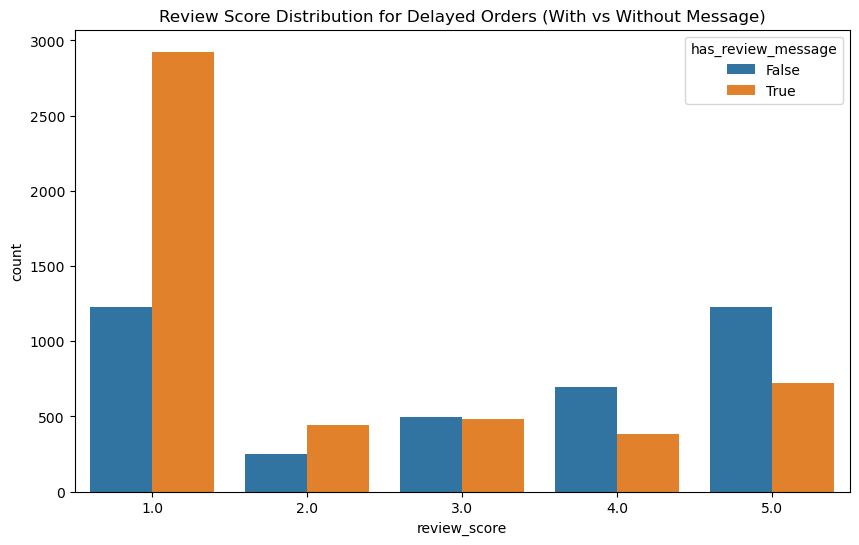

In [45]:
# 고객이 직접 불만을 텍스트로 남김  = 위험 신호 (가 지연과 만났을 때의 분포)

# 지연된 주문(is_delayed=True)만 추출하여 메시지 유무에 따른 점수 분포 확인
delayed_orders = main_df[main_df['is_delayed'] == True]

plt.figure(figsize=(10, 6))
sns.countplot(data=delayed_orders, x='review_score', hue='has_review_message')
plt.title('Review Score Distribution for Delayed Orders (With vs Without Message)')
plt.show()

In [ ]:
# 배송 지연 시, 리뷰 메세지 남긴 고객의 평점은 매우 낮음 (없는 고객보다 1점정도 낮음) 
# 능동적 표현  => 플랫폼 이탈 가능성 높음 

### 손익 연계 _ 결제 금액 분포 확인

In [ ]:
# 고액 결제 건이 지연될 때 리스크가 더 큰지 확인하기 위함 _ 결제 금액의 분포 확인

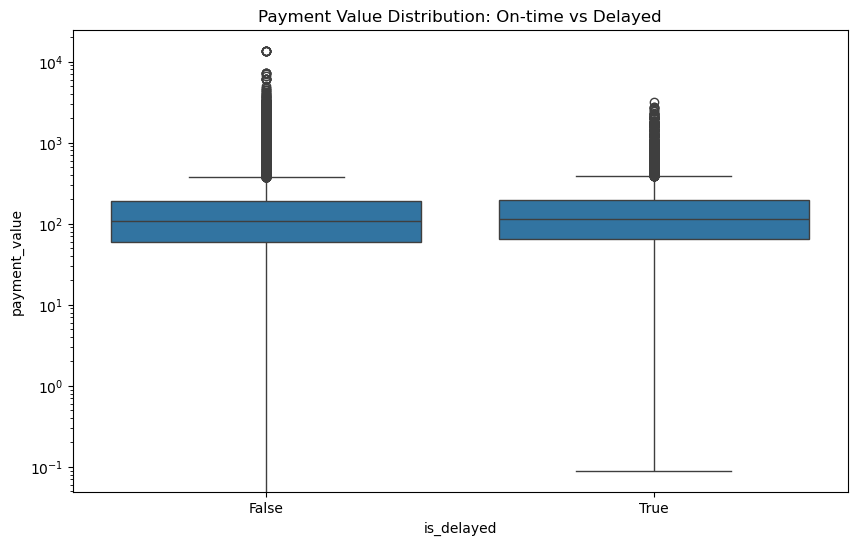

In [46]:
# 결제 금액 분포 (로그 스케일 적용하여 이상치 영향 감소)
plt.figure(figsize=(10, 6))
sns.boxplot(data=main_df, x='is_delayed', y='payment_value')
plt.yscale('log') # 금액 차이가 크므로 로그 스케일 사용
plt.title('Payment Value Distribution: On-time vs Delayed')
plt.show()

In [49]:
# 지연 주문 평균 결제 금액이 정상 주문보다 약간 더 높음 
# 비산 물건을 산 고객들도 지연 리스크에 노출되어 있음 


In [ ]:
# 결론 
# 지연율이 높으며 판매 금액이 큰 셀러  = 유의 판매자 